In [2]:
from sea_breeze.load_model_data import load_barra_variable
from climtas.nci import GadiClient
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from sea_breeze.sea_breeze_funcs import kinematic_frontogenesis
import xarray as xr
import geopandas
import metpy.units as units

In [3]:
GadiClient()

2025-01-30 09:56:35,550 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-01-30 09:56:35,555 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-01-30 09:56:35,601 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43165 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0003.gadi.nci.org.au/58002/proxy/43165/status,
Dashboard: /node/gadi-cpu-bdw-0003.gadi.nci.org.au/58002/proxy/43165/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44697,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0003.gadi.nci.org.au/58002/proxy/43165/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:32857,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0003.gadi.nci.org.au/58002/proxy/34451/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:41469,


In [5]:
#lon_slice = slice(108,159)
#lat_slice = slice(-45.7,-6.831799)    
#lat_slice=slice(-45,-30)
#lon_slice=slice(140,155)
lat_slice = slice(-42,-36)
lon_slice = slice(144,151)
t1 = "2015-12-01 00:00"
t2 = "2024-03-01 00:00"

In [6]:
offshore_regions = geopandas.read_file("/g/data/gb02/ab4502/coastline_data/Offshore_Renewable_Energy_Infrastructure_Regions/Offshore_Renewable_Energy_Infrastructure_Regions.shp")



In [9]:
barra_u = load_barra_variable("ua100m",t1,t2,"AUST-04","1hr",lat_slice,lon_slice,chunks={"lat":-1,"lon":-1,"time":-1})
barra_v = load_barra_variable("va100m",t1,t2,"AUST-04","1hr",lat_slice,lon_slice,chunks={"lat":-1,"lon":-1,"time":-1})

In [11]:
barra = xr.Dataset({"u":barra_u,"v":barra_v})

In [12]:
barra["ws"] = np.sqrt(barra["u"]**2 + barra["v"]**2)

In [17]:
barra_6Z = barra.sel(time=(np.in1d(barra.time.dt.hour,6)) & ((np.in1d(barra.time.dt.month,[12,1,2])))).mean("time").persist()

In [18]:
barra_18Z = barra.sel(time=(np.in1d(barra.time.dt.hour,18)) & ((np.in1d(barra.time.dt.month,[12,1,2])))).mean("time").persist()

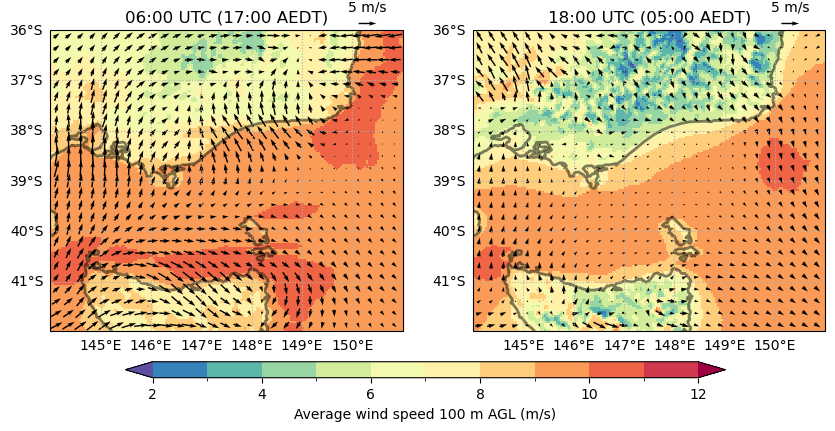

In [26]:
plt.figure(figsize=[10,4])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
c=barra_6Z.ws.plot(cmap="Spectral_r",vmin=2,vmax=12,levels=11,extend="both",add_colorbar=False)
q=barra_6Z.squeeze().coarsen({"lat":6,"lon":6},boundary="trim").mean().plot.quiver(ax=ax,x="lon",y="lat",u="u",v="v",width=0.004,scale=100,color="k",add_guide=False)
qk = plt.quiverkey(q,0.9,1.02,5,"5 m/s",coordinates="axes")
ax.coastlines(color="k",lw=2,alpha=0.5)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
plt.title("06:00 UTC (17:00 AEDT)")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c=barra_18Z.ws.plot(cmap="Spectral_r",vmin=2,vmax=12,levels=11,extend="both",add_colorbar=False)
q = barra_18Z.squeeze().coarsen({"lat":6,"lon":6},boundary="trim").mean().plot.quiver(ax=ax,x="lon",y="lat",u="u",v="v",width=0.004,scale=100,color="k",add_guide=False)
qk = plt.quiverkey(q,0.9,1.02,5,"5 m/s",coordinates="axes")
ax.coastlines(color="k",lw=2,alpha=0.5)
plt.title("18:00 UTC (05:00 AEDT)")
ax.gridlines(draw_labels=["left","bottom"],ls=":")

cax = plt.axes([0.2,0.002,0.6,0.04])
cb=plt.colorbar(c,cax=cax,orientation="horizontal")
cb.set_label("Average wind speed 100 m AGL (m/s)")

plt.savefig("/g/data/gb02/ab4502/figs/composite_ws.jpeg",dpi=1000,bbox_inches="tight")

In [19]:
wpd = xr.where((barra.ws>=3) & (barra.ws<25), 0.5 * 1.22 * barra.ws**3, 0)

In [20]:
wpd_6Z = wpd.sel(time=(np.in1d(barra.time.dt.hour,6)) & ((np.in1d(barra.time.dt.month,[12,1,2])))).mean("time").persist()

In [21]:
wpd_18Z = wpd.sel(time=(np.in1d(barra.time.dt.hour,18)) & ((np.in1d(barra.time.dt.month,[12,1,2])))).mean("time").persist()

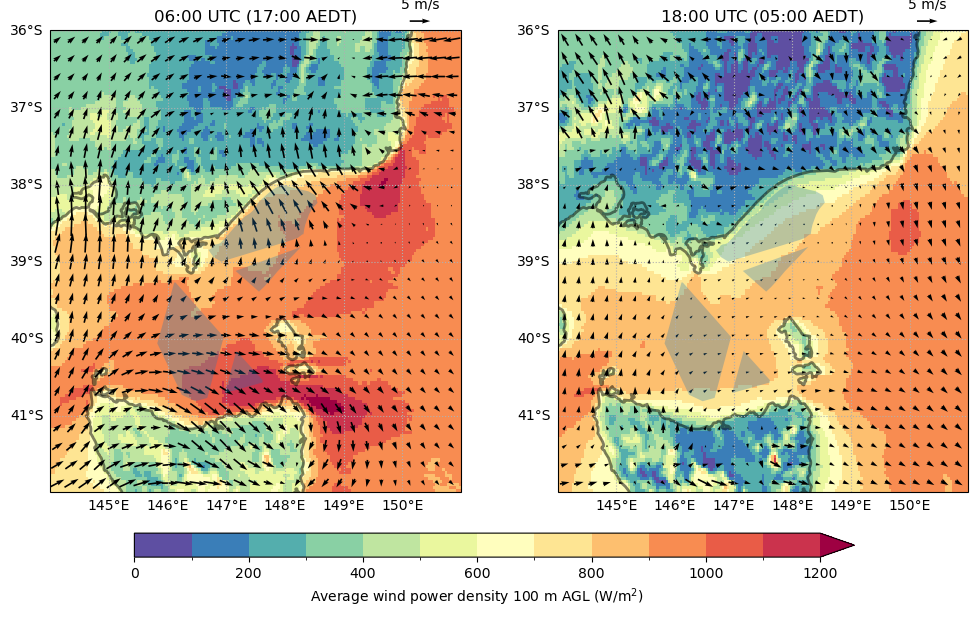

In [25]:
def plot_offshore_regions(ax):
    geopandas.GeoDataFrame(offshore_regions).loc[[1],"geometry"].plot(ax=ax,alpha=0.3)
    geopandas.GeoDataFrame(offshore_regions).loc[[2],"geometry"].plot(ax=ax,alpha=0.3)
    geopandas.GeoDataFrame(offshore_regions).loc[[3],"geometry"].plot(ax=ax,alpha=0.3)
    geopandas.GeoDataFrame(offshore_regions).loc[[13],"geometry"].plot(ax=ax,alpha=0.3)
    geopandas.GeoDataFrame(offshore_regions).loc[[14],"geometry"].plot(ax=ax,alpha=0.3)    

plt.figure(figsize=[12,6])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
c=wpd_6Z.plot(cmap="Spectral_r",levels=13,extend="max",add_colorbar=False,vmin=0,vmax=1200)
q=barra_6Z.squeeze().coarsen({"lat":6,"lon":6},boundary="trim").mean().plot.quiver(ax=ax,x="lon",y="lat",u="u",v="v",width=0.004,scale=100,color="k",add_guide=False)
qk = plt.quiverkey(q,0.9,1.02,5,"5 m/s",coordinates="axes")
ax.coastlines(color="k",lw=2,alpha=0.5)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
plt.title("06:00 UTC (17:00 AEDT)")
plot_offshore_regions(ax)

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c=wpd_18Z.plot(cmap="Spectral_r",levels=13,extend="max",add_colorbar=False,vmin=0,vmax=1200)
q = barra_18Z.squeeze().coarsen({"lat":6,"lon":6},boundary="trim").mean().plot.quiver(ax=ax,x="lon",y="lat",u="u",v="v",width=0.004,scale=100,color="k",add_guide=False)
qk = plt.quiverkey(q,0.9,1.02,5,"5 m/s",coordinates="axes")
ax.coastlines(color="k",lw=2,alpha=0.5)
plt.title("18:00 UTC (05:00 AEDT)")
ax.gridlines(draw_labels=["left","bottom"],ls=":")
plot_offshore_regions(ax)

cax = plt.axes([0.2,0.002,0.6,0.04])
cb=plt.colorbar(c,cax=cax,orientation="horizontal")
cb.set_label("Average wind power density 100 m AGL (W/m$^{2}$)")

plt.savefig("/g/data/gb02/ab4502/figs/composite_power.jpeg",dpi=1000,bbox_inches="tight")

/home/548/ab4502/working/sea_breeze/sea_breeze_funcs.py:191: UserWarning: More than one vertical coordinate present for variable  "huss".
  Fq = mpcalc.frontogenesis(q,


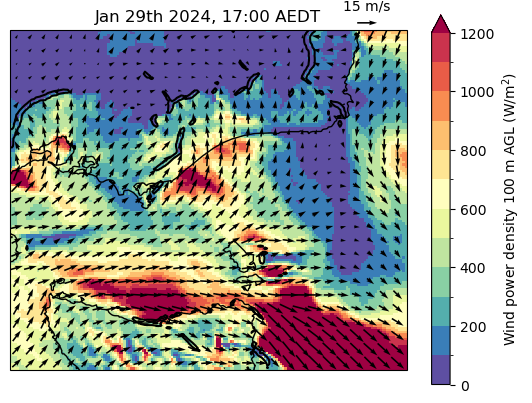

In [15]:
t = "2024-01-29 06:00"
barra_sfc = load_barra_variable(["huss","uas","vas"],t,t,"AUST-04","1hr",lat_slice,lon_slice)
F = kinematic_frontogenesis(barra_sfc["huss"]["huss"]*units.units("K"),
                            barra_sfc["uas"]["uas"]*units.units("m/s"),
                            barra_sfc["vas"]["vas"]*units.units("m/s")).compute()

ax=plt.axes(projection=ccrs.PlateCarree())
c=wpd.sel(time=t).plot(cmap="Spectral_r",levels=13,extend="max",add_colorbar=False,vmin=0,vmax=1200)
q=barra.sel(time=t).squeeze().coarsen({"lat":6,"lon":6},boundary="trim").mean().plot.quiver(ax=ax,x="lon",y="lat",u="u",v="v",width=0.004,scale=300,color="k",add_guide=False)
qk = plt.quiverkey(q,0.9,1.02,15,"15 m/s",coordinates="axes")
xr.plot.contour(F.squeeze(),levels=[0.05],colors="k")
ax.coastlines()
ax.set_title("Jan 29th 2024, 17:00 AEDT")
cb=plt.colorbar(c)
cb.set_label("Wind power density 100 m AGL (W/m$^{2}$)")

plt.savefig("/g/data/gb02/ab4502/figs/power_snapshot.jpeg",dpi=1000,bbox_inches="tight")

In [16]:
barra_sfc["huss"]["huss"]

<xarray.DataArray 'huss' (time: 1, lat: 150, lon: 175)> Size: 210kB
dask.array<getitem, shape=(1, 150, 175), dtype=float64, chunksize=(1, 150, 175), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) datetime64[ns] 8B 2024-01-29T06:00:00
  * lat                 (lat) float64 1kB -41.97 -41.93 -41.89 ... -36.05 -36.01
  * lon                 (lon) float64 1kB 144.0 144.1 144.1 ... 150.9 151.0
    level_height        float64 8B ...
    model_level_number  int32 4B ...
    sigma               float64 8B ...
    height              float64 8B ...
    crs                 int32 4B ...
Attributes:
    long_name:      Near-Surface Specific Humidity
    standard_name:  specific_humidity
    units:          1
    cell_methods:   time: point (interval: 1H)
    grid_mapping:   crs

In [18]:
barra_sfc["vas"]["vas"]

<xarray.DataArray 'vas' (time: 1, lat: 150, lon: 175)> Size: 210kB
dask.array<getitem, shape=(1, 150, 175), dtype=float64, chunksize=(1, 150, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-01-29T06:00:00
    height   float64 8B ...
  * lon      (lon) float64 1kB 144.0 144.1 144.1 144.1 ... 150.9 150.9 151.0
  * lat      (lat) float64 1kB -41.97 -41.93 -41.89 ... -36.09 -36.05 -36.01
    crs      int32 4B ...
Attributes:
    long_name:      Northward Near-Surface Wind
    standard_name:  northward_wind
    units:          m s-1
    cell_methods:   time: point (interval: 1H) area: interpolation (method: b...
    grid_mapping:   crs